# Importing Libraries

In [16]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

In [17]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001DCDBDF32C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DCD799C3B0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

# Loading Knowledge Base

In [2]:
from langchain.document_loaders import TextLoader
loader = TextLoader(file_path=r"./car_inventory.txt")
docs = loader.load()

In [3]:
docs

[Document(metadata={'source': './car_inventory.txt'}, page_content='2023 Tesla Model 3 (Performance, used) is available at BMW of Fremont in New Jasonhaven, PR. It is a Coupe with Automatic transmission, runs on Hybrid, and has 32,594 miles. The MSRP is $34,371 with a discount of $500, bringing the final price to $33,871.\nFeatures include: 4WD/AWD, Auto Dimming Mirror, Remote Start.\nCurrent offers: GM Educator Offer ($-500); Purchase Allowance ($-500).\nVIN: N6R0D6K9D7M3W0V6U7M0L1A2G1W5K8 | Stock Number: BMW001.\nImage: https://example.com/images/tesla_model3.jpg\n\n2025 BMW X5 (xDrive40i, certified) is available at Concord Acura in Franciscoside, AZ. It is a Truck with Automatic transmission, runs on Electric, and has 27,298 miles. The MSRP is $32,958 with a discount of $2,000, bringing the final price to $30,958.\nFeatures include: Apple CarPlay, Lane Departure Warning, Bluetooth, 4WD/AWD.\nCurrent offers: Purchase Allowance for Current Eligible Non-GM Owners and Lessees ($-2,000).

In [4]:
from langchain.text_splitter import CharacterTextSplitter
splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=700,     # Optional: max token/char size
    chunk_overlap=0
)

# Step 3: Split the loaded documents
split_docs = splitter.split_documents(docs)
len(split_docs), type(split_docs)

(500, list)

In [5]:
split_docs

[Document(metadata={'source': './car_inventory.txt'}, page_content='2023 Tesla Model 3 (Performance, used) is available at BMW of Fremont in New Jasonhaven, PR. It is a Coupe with Automatic transmission, runs on Hybrid, and has 32,594 miles. The MSRP is $34,371 with a discount of $500, bringing the final price to $33,871.\nFeatures include: 4WD/AWD, Auto Dimming Mirror, Remote Start.\nCurrent offers: GM Educator Offer ($-500); Purchase Allowance ($-500).\nVIN: N6R0D6K9D7M3W0V6U7M0L1A2G1W5K8 | Stock Number: BMW001.\nImage: https://example.com/images/tesla_model3.jpg'),
 Document(metadata={'source': './car_inventory.txt'}, page_content='2025 BMW X5 (xDrive40i, certified) is available at Concord Acura in Franciscoside, AZ. It is a Truck with Automatic transmission, runs on Electric, and has 27,298 miles. The MSRP is $32,958 with a discount of $2,000, bringing the final price to $30,958.\nFeatures include: Apple CarPlay, Lane Departure Warning, Bluetooth, 4WD/AWD.\nCurrent offers: Purchase

In [6]:
db = Chroma.from_documents(split_docs, embedding_function)
db

In [7]:
retriever = db.as_retriever(search_kwargs={"k": 2})
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001DC4AD7C620>, search_kwargs={'k': 2})

# RAG Prompt

In [8]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration: " \

Chathistory: {history}

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
print(prompt)

input_variables=['context', 'history', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'history', 'question'], input_types={}, partial_variables={}, template='Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration: " \nChathistory: {history}\n\nContext: {context}\n\nQuestion: {question}\n'), additional_kwargs={})]


In [9]:
rag_chain = prompt | llm
rag_chain

ChatPromptTemplate(input_variables=['context', 'history', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'history', 'question'], input_types={}, partial_variables={}, template='Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration: " \nChathistory: {history}\n\nContext: {context}\n\nQuestion: {question}\n'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001DC4AD0AF60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DC4AD0BD40>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
from typing import TypedDict, List, Optional

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

from langgraph.graph import START, END, StateGraph


class AgentState(BaseModel):
    messages: Optional[List[BaseMessage]] =[]
    documents: Optional[List[Document]] = []
    on_topic: Optional[str] = ""
    rephrased_question: Optional[str] = ""
    proceed_to_generate: Optional[bool] = False
    rephrase_count: Optional[int] = 0
    question: HumanMessage

In [ ]:
class GradeQuestion(BaseModel):
    """
    Boolean value to check weather a question is related to the Cars
    """
    score: str = Field(description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'")


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    state.documents = []
    state.on_topic = ""
    state.rephrased_question = ""
    state.proceed_to_generate = False
    state.rephrase_count = 0

    # if "messages" not in state or state.messages is None:
    if not hasattr(state, "messages") or state.messages is None:
        state.messages = []

    if state.question not in state.messages:
        state.messages.append(state.question)
    
    if len(state.messages) > 1:
        conversation = state.messages[:-1]
        current_question = state.question.content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval"
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)

        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased Question: {better_question}")
        state.rephrased_question = better_question
    else:
        state.rephrased_question = state.question.content
    return state


def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question is about one of the following topics:
1. Information about Cars
2. Prices of the Cars
3. Features of the Cars
4. Offers of the Cars

If the question is about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.
Remember, Only YES or NO, nothing else in the response!
    """
    )
    human_message = HumanMessage(
        content=f"User Question: {state.rephrased_question}"
    )

    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])

    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state.on_topic = result.score.strip()
    print(f"question_classifier: on_topic = {state.on_topic}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    # on_topic = state.get("on_topic", "").strip().lower()
    on_topic = (state.on_topic or "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"
    
def retrieve(state: AgentState):
    print("Entering Retrieve")
    documents = retriever.invoke(state.rephrased_question)
    print(f"retrieve: Retrieved {len(documents)} documents")
    state.documents = documents
    return state

In [26]:
class GradeDocument(BaseModel):
    """
    Boolean value to check weather a document is related to the question
    """
    score: str = Field(description="Document is relevant to the question> If yes -> 'Yes' if not -> 'No'")


def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
        Only answer with 'Yes' or 'No'.
        If the document contains information relevant to the user's question, respond with 'Yes'.
        Otherwise, respond with 'No'."""
    )

    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []

    print(len(state.documents))
    
    for_loop_check = False

    for doc in state.documents:
        for_loop_check = True
        human_message = HumanMessage(
            content=f"User question: {state.rephrased_question}\n\nRetrieved document:\n{doc.page_content}"
        )

        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(f"Grading document: {doc.page_content[:30]}.... Result: {result.score.strip()}")
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    
    state.documents = relevant_docs
    state.proceed_to_generate = len(relevant_docs) > 0
    print(f"Did it enter for loop?: {for_loop_check}")
    print(f"retrieval_grader: proceed_to_generate = {state.proceed_to_generate}")
    return state



def proceed_router(state: AgentState):
    print("Entering proceed_router")
    # rephrase_count = state.get("rephrase_count", 0)
    rephrase_count = state.rephrase_count or 0
    proceed_to_generate = state.proceed_to_generate or False
    if proceed_to_generate:
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"


def refine_question(state: AgentState):
    print("Entering refine_question")
    # rephrase_count = state.get("rephrase_count", 0)
    rephrase_count = state.rephrase_count or 0
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached.")
        return state
    
    question_to_refine = state.rephrased_question
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
        Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question.")
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined Question: {refined_question}")
    state.rephrased_question = refined_question
    state.rephrase_count = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    # if "messages" not in state or state.messages is None:
    if not hasattr(state, "messages") or state.messages is None:
        raise ValueError("State must include 'messages' before generating an answer.")
    
    history = state.messages
    documents = state.documents
    rephrased_question = state.rephrased_question

    response = rag_chain.invoke({
        'history': history,
        'context': documents,
        'question': rephrased_question
    })

    generation = response.content.strip()

    state.messages.append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")


def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if 'messages' not in state or state.messages is None:
        state.messages = []
    state.messages.append(AIMessage(content="I'm sorry, but I cannot find the information you're for looking for."))
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    # if "messages" not in state or state.messages is None:
    if not hasattr(state, "messages") or state.messages is None:
        state.messages = []

    state.messages.append(AIMessage(content="I can't respond to that!"))
    return state


# Memory

In [27]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

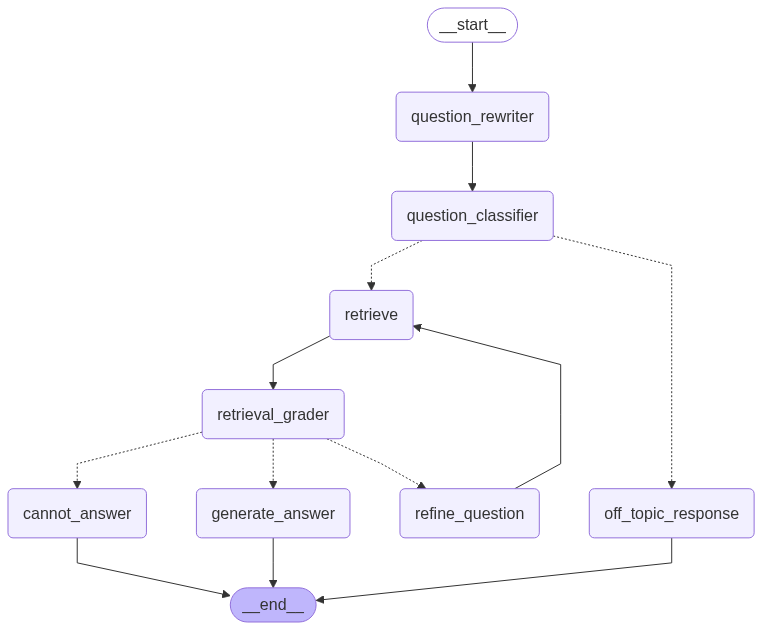

In [28]:
workflow = StateGraph(AgentState)

workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)


workflow.add_edge("question_rewriter", "question_classifier")

workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)

workflow.add_edge("retrieve", "retrieval_grader")

workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer"
    },
)

workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)

workflow.set_entry_point("question_rewriter")

graph = workflow.compile(checkpointer=checkpointer)

graph




# OFF Topic

In [29]:
question1 = HumanMessage(content="How is the weather")
input_data = {"question": question1}
res1 = graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})
res1

Entering question_rewriter with following state: messages=[] documents=[] on_topic='' rephrased_question='' proceed_to_generate=False rephrase_count=0 question=HumanMessage(content='How is the weather', additional_kwargs={}, response_metadata={})
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='How is the weather', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'How is the weather',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='How is the weather', additional_kwargs={}, response_metadata={})}

# No docs found

In [30]:
question2 = HumanMessage(content="Who is the owner of the Car 2024 Acura Integra")
res2 = graph.invoke(input={"question": question2}, config={"configurable": {"thread_id": 2}})
res2

Entering question_rewriter with following state: messages=[] documents=[] on_topic='' rephrased_question='' proceed_to_generate=False rephrase_count=0 question=HumanMessage(content='Who is the owner of the Car 2024 Acura Integra', additional_kwargs={}, response_metadata={})
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='Who is the owner of the Car 2024 Acura Integra', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'Who is the owner of the Car 2024 Acura Integra',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='Who is the owner of the Car 2024 Acura Integra', additional_kwargs={}, response_metadata={})}

# RAG with History

In [31]:
question3 = HumanMessage(content="What are the cars available under 50K $")
res3 = graph.invoke(input={"question": question3}, config={"configurable": {"thread_id": 3}})
res3

Entering question_rewriter with following state: messages=[] documents=[] on_topic='' rephrased_question='' proceed_to_generate=False rephrase_count=0 question=HumanMessage(content='What are the cars available under 50K $', additional_kwargs={}, response_metadata={})
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering Retrieve
retrieve: Retrieved 2 documents
Entering retrieval_grader
2
Grading document: 2023 BMW X5 (M50i, new) is ava.... Result: Yes
Grading document: 2025 BMW X5 (M50i, used) is av.... Result: Yes
Did it enter for loop?: True
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: **Cars priced under $50 000**

| Year | Make & Model | Trim | New/Used | Final Price | Location |
|------|--------------|------|----------|-------------|----------|
| 2023 | BMW X5 | M50i (new) | New | **$34,793** | Concord Acu

{'messages': [HumanMessage(content='What are the cars available under 50K $', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': './car_inventory.txt'}, page_content='2023 BMW X5 (M50i, new) is available at Concord Acura in Lisaberg, CT. It is a SUV with Automatic transmission, runs on Diesel, and has 10 miles. The MSRP is $37,793 with a discount of $3,000, bringing the final price to $34,793.\nFeatures include: Remote Start, Keyless Entry, Apple CarPlay, Cooled Seats, Lane Departure Warning, Super Cruise.\nCurrent offers: Purchase Allowance for Current Eligible Non-GM Owners and Lessees ($-2,000).\nVIN: M0C5R9C1V7N4Y0T7F2X1F4Z7Z9V0F6 | Stock Number: CONC258.\nImage: https://example.com/images/bmw_x5.jpg'),
  Document(metadata={'source': './car_inventory.txt'}, page_content='2025 BMW X5 (M50i, used) is available at Tesla San Jose in East Richard, MP. It is a Sedan with CVT transmission, runs on Diesel, and has 49,685 miles. The MSRP is $41,394 wit

In [34]:
question4 = HumanMessage(content="I want a car under $25K")
res4 = graph.invoke(input={"question": question4}, config={"configurable": {"thread_id": 3}})
res4

Entering question_rewriter with following state: messages=[HumanMessage(content='I want a car under $25K', additional_kwargs={}, response_metadata={})] documents=[] on_topic='' rephrased_question='I want a car under $25K' proceed_to_generate=False rephrase_count=0 question=HumanMessage(content='I want a car under $25K', additional_kwargs={}, response_metadata={})
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering Retrieve
retrieve: Retrieved 2 documents
Entering retrieval_grader
2
Grading document: 2025 Acura Integra (A-Spec Tec.... Result: No
Grading document: 2025 Acura Integra (Type S, ne.... Result: No
Did it enter for loop?: True
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined Question: <think>
Okay, so the user wants to buy a car that's under $25,000. Let me think about how to refine their question to get better res

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'Yes'}}